In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.special as spc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

We'll first go over some intuition-building examples with the bootstrap:

In [7]:
def bootstrap_1d(samples, mu, B=1000, plot=True, fnc=np.mean):
    mu_hat = fnc(samples)
    mu_boot = np.zeros(shape=(B,))
    for b in range(B):
        bootstrap_samples = rnd.choice(samples, N)
        mu_boot[b] = fnc(bootstrap_samples)
    if plot:
        low = np.min(mu_boot)
        high = np.max(mu_boot)
        length = high - low
        low, high = low - 0.1 * length, high + 0.1 * length
        plt.hist(mu_boot, bins=np.arange(low, high, 0.05 * length))
        plt.axvline(mu_hat, color='r', linestyle='dashed', linewidth=3)
        plt.axvline(mu, color='g', linestyle='dashed', linewidth=3)
        plt.title('Bootstrap estimates')
        plt.show()
    return mu_boot

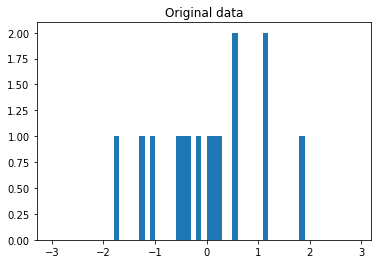

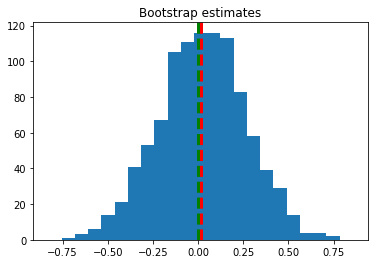

Estimated stdev: 0.241
True stdev: 0.258


In [29]:
# Mean estimation
# 1: Gaussian
mu = 0.0
sigma = 1.0
N = 15
samples = rnd.normal(mu, sigma, N)
plt.hist(samples, bins=np.arange(-3, 3, .1))
plt.title('Original data')
plt.show()
mu_boot = bootstrap_1d(samples, mu, fnc=np.mean)
print('Estimated stdev: %.3f' % np.std(mu_boot))
print('True stdev: %.3f' % (sigma / np.sqrt(N)))

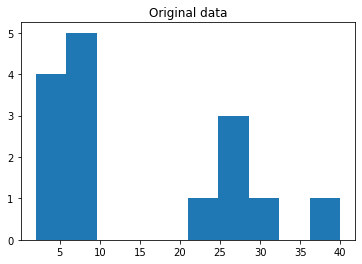

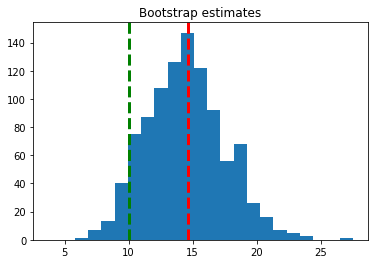

Estimated stdev (bootstrap): 3.036
Estimated stdev (simple) 3.116
True stdev: 2.449


In [32]:
# 2: Geometric
r = 0.1
N = 15
samples = rnd.geometric(r, N)
plt.hist(samples)
plt.title('Original data')
plt.show()
mu_boot = bootstrap_1d(samples, 1.0/r)
print('Estimated stdev (bootstrap): %.3f' % np.std(mu_boot))
print('Estimated stdev (simple) %.3f' % (np.std(samples) / np.sqrt(N-1)))
print('True stdev: %.3f' % ((np.sqrt(1-r)/r) / np.sqrt(N)))

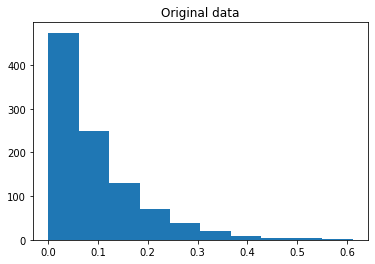

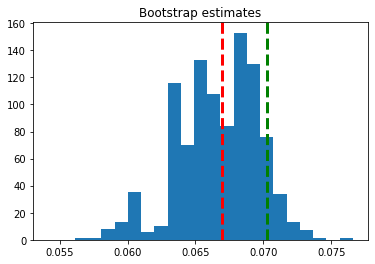

In [36]:
r = 0.1
N = 999
samples = rnd.exponential(r, N)
samples_large = rnd.exponential(r, 10000)
fnc = lambda x : np.median(x)
plt.hist(samples)
plt.title('Original data')
plt.show()
bootstrap_1d(samples, fnc(samples_large), fnc=fnc);
#fnc = lambda x : np.quantile(x, 0.8)
#bootstrap_1d(samples, fnc(samples_large), fnc=fnc);

In [25]:
def logistic_regression(X, y):
    return LogisticRegression(solver='lbfgs', fit_intercept=False).fit(X, y).coef_[0]


def bootstrap_xy(X, y, w=None, B=1000, fnc=logistic_regression, plot=True):
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        bootstrap_indices = rnd.choice(np.arange(N), N)
        bootstrap_X = X[bootstrap_indices, :]
        bootstrap_y = y[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    if plot:
        plt.scatter(w_boot[:,0], w_boot[:,1], c='b')
        plt.scatter(w_hat[0], w_hat[1], c='r', marker='x', s=300)
        if w is not None:
            plt.scatter(w[0], w[1], c='g', marker='x', s=300)
        plt.show()
    return w_boot

[ 4. -2.]
[ 3.22906663 -1.58378967]


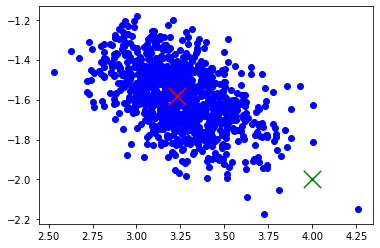

In [45]:
N = 500
d = 2
sigmoid = spc.expit
w = 2.0 * np.array([2, -1])
#w = np.array([1, 2, -1, -2, 1, 1, 1, 1, 1, 1])
X = rnd.randn(N,d)
z = np.sum(X*w, 1)
y = rnd.binomial(1, sigmoid(z))
w_hat = logistic_regression(X, y)
print(w)
print(w_hat)
bootstrap_xy(X, y, w, B=1000);

Finally, let's use the bootstrap to fix the issues with the Poisson model:

In [46]:
# New York State
days = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
counts = np.array([47, 50, 117, 137, 158, 264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805, 5327])
# Santa Clara County
#days = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
#counts = np.array([1, 2, 2, 4, 5, 6, 6, 8, 8, 10, 13, 16, 17, 19, 20])
new_counts = np.diff(counts)
days = days[1:]

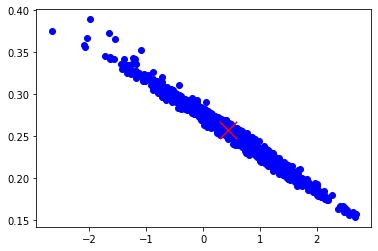

In [47]:
def get_beta(X, y):
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()
    return poisson_results.params # params[0] is intercept term
                                  # params[1] is days term
samples = bootstrap_xy(sm.add_constant(days), new_counts, fnc=get_beta)

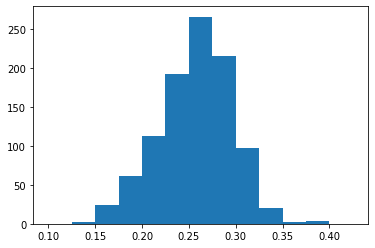

Median: 0.259
5th percentile: 0.187
95th percentile: 0.316


In [10]:
plt.hist(samples[:,1], bins=np.arange(0.10, 0.45, 0.025))
plt.show()
print('Median: %.3f' % np.median(samples[:,1]))
print('5th percentile: %.3f' % np.quantile(samples[:,1], 0.05))
print('95th percentile: %.3f' % np.quantile(samples[:,1], 0.95))